In [192]:
import random
from collections import Counter

# use opencv kernel
import cv2

from PIL import Image, ImageOps

import numpy as np

from scipy.io import loadmat
from scipy.ndimage import imread
from scipy.misc import toimage, fromimage

from skimage import data, io, filters

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import SGDClassifier

# Load Data

In [193]:
# limit number of data points
lim_train = 100
#lim_test = 1000

train_data = loadmat('data/train_32x32.mat', variable_names='X').get('X')[:,:,:,:lim_train]
train_labels = loadmat('data/train_32x32.mat', variable_names='y').get('y')[:lim_train]

#test_data = loadmat('data/test_32x32.mat', variable_names='X').get('X')[:,:,:,:lim_test]
#test_labels = loadmat('data/test_32x32.mat', variable_names='y').get('y')[:lim_test]

#extra_data = loadmat('data/extra_32x32.mat', variable_names='X').get('X')[:,:,:,:1]
#extra_labels = loadmat('data/extra_32x32.mat', variable_names='y').get('y')[:1]

In [194]:
print('Training data shape: {0} | Training labels shape: {1}'.format(train_data.shape, train_labels.shape))
#print('Testing data shape:  {0}  | Testing labels shape:  {1}'.format(test_data.shape, test_labels.shape))
#print('Extra data shape:    {0}     | Extra labels shape:    {1}'.format(extra_data.shape, extra_labels.shape))

Training data shape: (32, 32, 3, 100) | Training labels shape: (100, 1)


In [195]:
train_data = train_data.transpose((3,0,1,2))
#test_data = test_data.transpose((3,0,1,2))
#extra_data = extra_data.transpose((3,0,1,2))

In [196]:
print('Training data shape: {0} | Training labels shape: {1}'.format(train_data.shape, train_labels.shape))
#print('Testing data shape:  {0}  | Testing labels shape:  {1}'.format(test_data.shape, test_labels.shape))
#print('Extra data shape:    {0}     | Extra labels shape:    {1}'.format(extra_data.shape, extra_labels.shape))

Training data shape: (100, 32, 32, 3) | Training labels shape: (100, 1)


In [197]:
one_img = train_data[:,:,:,:][0]
one_img.shape

(32, 32, 3)

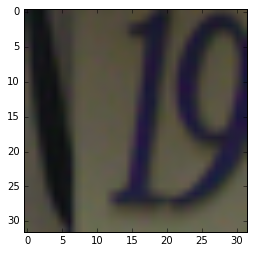

In [198]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(one_img)

# Conversion with Color Limit

In [494]:
def gray_conv(image, num_shades):
    # input: image array(h,w), and number of desired gray shades
    # output: list of converted rgb values
    if num_shades < 255 or num_shades > 2:
        x, y, _ = image.shape
        gray = []
        
        for i in range(x):
            for j in range(y):
                conv = 255 / (num_shades - 1)
                avg = (sum(image[i][j])) / 3
                gray.append(int(int(round(avg / conv)) * conv))
    return np.array(gray)

def img_arr_conv(lst,w,h):
    # ONLY NEEDED FOR VIEWING IMAGES - NOT ANALYSIS
    # input: list with image height and width
    # output: image array(32,32)
    result = np.array(lst)
    result = np.ndarray.reshape(result, (w,h))
        
    return result

def conv_gray_2d_arr(img_arr, col_left, col_right, num_shades):
    num_imgs, _, _, _ = img_arr.shape
    
    arr_2d = []
    
    for i in range(num_imgs):
        img = img_arr[:,:,:,:][i]
        img_trim = img[:, col_left:col_right]
        
        gray_img = gray_conv(img_trim, num_shades)
        
        arr_2d.append(gray_img)
    
    return np.asarray(arr_2d)

In [506]:
conv_gray_2d_arr(train_data, col_left=6, col_right=26, num_shades=32)

array([[ 57,  65,  74, ...,  98,  98,  98],
       [ 32,  24,  41, ...,  98,  98,  98],
       [ 65,  65,  74, ..., 156, 156, 156],
       ..., 
       [139, 139, 139, ...,  32,  32,  32],
       [123, 123, 123, ..., 148, 148, 148],
       [115, 115, 123, ..., 148, 148, 148]])

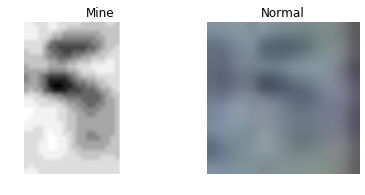

In [503]:
img_num = 5
shades = 32

orig_img = train_data[:,:,:,:][img_num]
scaled_img = img_arr_conv(gray_conv(orig_img, shades), 32, 32)
scaled_img = scaled_img[:,6:26]

fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})
ax0.imshow(scaled_img, cmap='Greys_r')
ax0.set_title('Mine')
ax0.axis('off')
ax1.imshow(orig_img)
ax1.set_title('Normal')
ax1.axis('off')
plt.show()

# OpenCV Adaptive Threshold

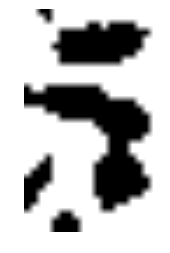

In [504]:
# retval, thresh = cv2.threshold(a, 4, 255, cv2.THRESH_BINARY)
a = train_data[:,:,:,:][5]
grayscaled = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)

gaus = cv2.adaptiveThreshold(grayscaled, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 1)

# trim to number of focus
gaus = gaus[:,6:26]

plt.imshow(gaus, cmap='Greys_r')
plt.axis('off')
_ = plt.show

In [3]:
# set training labels of 10 equal to 0
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0
extra_labels[extra_labels == 10] = 0

In [17]:
test_data = test_data.transpose((3,0,1,2))
train_labels = np.ravel(train_labels)
test_labels = np.ravel(test_labels)
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(32, 32, 3, 10000) (10000,)
(3, 1000, 32, 32) (1000,)


In [18]:
image_size = 32  # image height and width
pixel_depth = 255.0  

def im2gray(image):
    '''Normalize images'''
    image = image.astype(float)
    # grayscale conversion per http://www.eyemaginary.com/Rendering/TurnColorsGray.pdf
    image_gray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    r = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    g = np.dot(image, [[0.5000],[0.5000],[0.1140]])
    b = np.dot(image, [[1.0000],[-1.0000],[0.0000]])
    return image_gray

train_data_c = im2gray(train_data_t)[:,:,:,0]
test_data_c = im2gray(test_data)[:,:,:,0]
valid_data_c = im2gray(valid_data)[:,:,:,0]

print(train_data_c.shape, train_labels_t.shape)
print(test_data_c.shape, test_labels.shape)
print(valid_data_c.shape, valid_labels.shape)

(6000, 32, 32) (6000,)
(1000, 32, 32) (1000,)
(4001, 32, 32) (4001,)


In [ ]:
def GCN(image, min_divisor=1e-4):
    """Global Contrast Normalization"""
    
    imsize = image.shape[0]
    mean = np.mean(image, axis=(1,2), dtype=float)
    std = np.std(image, axis=(1,2), dtype=float, ddof=1)
    std[std < min_divisor] = 1.
    image_GCN = np.zeros(image.shape, dtype=float)
    
    for i in np.arange(imsize):
        image_GCN[i,:,:] = (image[i,:,:] - mean[i]) / std[i]
        
    return image_GCN

train_data_GCN = GCN(train_data_c)
test_data_GCN = GCN(test_data_c)
valid_data_GCN = GCN(valid_data_c)

print(train_data_GCN.shape, train_labels_t.shape)
print(test_data_GCN.shape, test_labels.shape)
print(valid_data_GCN.shape, valid_labels.shape)

In [ ]:
# logistic regression classifier
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=0.001, shuffle=True, verbose=0, 
                    n_jobs=4, random_state=None, learning_rate='optimal')

clf.fit(train_data_c.reshape(train_data_GCN.shape[0],-1), train_labels_t)

train_prediction = clf.predict(train_data_GCN.reshape(train_data_GCN.shape[0],-1))
valid_prediction = clf.predict(valid_data_GCN.reshape(valid_data_GCN.shape[0],-1))

print('Training score is', clf.score(train_data_GCN.reshape(train_data_GCN.shape[0],-1), train_labels_t))
print('Validation score is', clf.score(valid_data_GCN.reshape(valid_data_GCN.shape[0],-1), valid_labels))
print('-'*80)
print('Classification report of training data:\n', classification_report(train_labels_t, train_prediction))
print('Confusion Matrix of training data:\n', confusion_matrix(train_labels_t, train_prediction))

print('Classification report of validation data:\n', classification_report(valid_labels, valid_prediction))
print('Confusion Matrix of validation data:\n', confusion_matrix(valid_labels, valid_prediction))

# SVM

In [ ]:
svm_clf = SVC(gamma=0.001, C=100.)
svm_mdl = svm_clf.fit(train_data_c.reshape(train_data_GCN.shape[0],-1), train_labels_t)

In [ ]:
print('Training score is', svm_mdl.score(train_data_GCN.reshape(train_data_GCN.shape[0],-1), train_labels_t))
print('Validation score is', svm_mdl.score(valid_data_GCN.reshape(valid_data_GCN.shape[0],-1), valid_labels))

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(train_labels_t, svm_mdl.predict(train_data_GCN.reshape(train_data_GCN.shape[0],-1)))